# Deep Learning for High Energy Particle Physics

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

## Reading in the Data

In [2]:
train = pd.read_csv('all_train.csv.gz')

In [3]:
train.head()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


## Scaling Mass

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train['mass'] = scaler.fit_transform(train['mass'].reshape(-1,1))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [5]:
from sklearn.model_selection import train_test_split
X = train.drop(['# label'], axis=1)
y = train['# label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600000 entries, 2283322 to 6413414
Data columns (total 28 columns):
f0      float64
f1      float64
f2      float64
f3      float64
f4      float64
f5      float64
f6      float64
f7      float64
f8      float64
f9      float64
f10     float64
f11     float64
f12     float64
f13     float64
f14     float64
f15     float64
f16     float64
f17     float64
f18     float64
f19     float64
f20     float64
f21     float64
f22     float64
f23     float64
f24     float64
f25     float64
f26     float64
mass    float64
dtypes: float64(28)
memory usage: 1.2 GB


## Training Deep Neural Networks in Keras

In [7]:
from keras.regularizers import l2 # L2 regularization
from keras.callbacks import EarlyStopping
from keras.optimizers import *

def create_deep_neural_net(num_inputs, hidden_layer_sizes, l2_val, num_outputs, optimizer):
    
    model = Sequential()
    first = True
    for hidden_layer_size in hidden_layer_sizes:
        if first:
            model.add(Dense(hidden_layer_size, 
                        activation='sigmoid', 
                        input_dim=num_inputs, kernel_regularizer=l2(l2_val)))
            first = False
        else:
            model.add(Dense(hidden_layer_size, 
                        activation='sigmoid', 
                        kernel_regularizer=l2(l2_val)))
        
    model.add(Dense(num_outputs, activation='sigmoid'))


    # compiling model
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

### Uniform Width Network

In [11]:
from keras.regularizers import l2 # L2 regularization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

L2_CONSTANT = 1e-7 # L2 regularization constant
layers = [28] * 5 # 5 layers of size 28

sgd = SGD(lr=0.01, momentum=0.95)

callbacks = [reduce_lr, early_stopping]


uniform_width_network = create_deep_neural_net(num_inputs=28, 
                                      hidden_layer_sizes=layers,
                                      l2_val = L2_CONSTANT,
                                      num_outputs=1,
                                      optimizer=sgd)

print(uniform_width_network.summary())
uniform_width_history = uniform_width_network.fit(X_train.values, y_train.values, 
                 validation_data=(X_valid.values, y_valid.values), callbacks=callbacks, epochs=50, batch_size=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_8 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_9 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_10 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_11 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 29        
Total params: 4,089
Trainable params: 4,089
Non-trainable params: 0
_________________________________________________________________
None
Tra

In [17]:
uniform_width_history.history['val_acc']

[0.8701766666666667, 0.8738790476190477, 0.8755861904761905]

### Tuning The Number of Layers

Fitting neural network with 1 hidden layer
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 29        
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________
None
Train on 4900000 samples, validate on 2100000 samples
Epoch 1/50
4900000/4900000 [==============================] - 16s - loss: 0.3472 - acc: 0.8398 - val_loss: 0.3095 - val_acc: 0.8566
Epoch 2/50
4900000/4900000 [==============================] - 16s - loss: 0.3022 - acc: 0.8593 - val_loss: 0.2963 - val_acc: 0.8622
Epoch 3/50
4900000/4900000 [==============================] - 15s - loss: 0.2948 - acc: 0.8627 - val_loss: 0.2919 - val_acc: 0.8644
Epoch 4/50
4900000/4900000 [==============

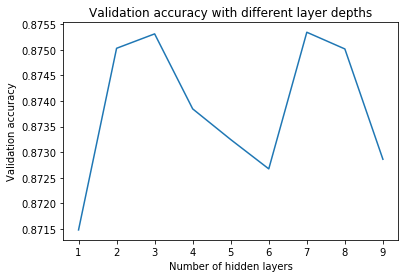

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, mode='min')
val_accs = []
for num_layers in range(1, 8):
    L2_CONSTANT = 1e-7 # L2 regularization constant
    layers = [28] * num_layers # 5 layers of size 28

    uniform_width_network = create_deep_neural_net(num_inputs=28, 
                                      hidden_layer_sizes=layers,
                                      l2_val = L2_CONSTANT,
                                      num_outputs=1,
                                      learning_rate = 0.001)
    if num_layers == 1:
        print('Fitting neural network with 1 hidden layer')
    else:
        print('Fitting neural network with {} hidden layers'.format(num_layers))
    print(uniform_width_network.summary())
    uniform_width_history = uniform_width_network.fit(X_train.values, y_train.values, 
                 validation_data=(X_valid.values, y_valid.values), epochs=20, 
                                                      batch_size=1024,
                                                     callbacks=[early_stopping])
    val_accs.append(uniform_width_history.history['val_acc'][-1])

plt.title('Validation accuracy with different layer depths')
plt.xlabel('Number of hidden layers')
plt.ylabel('Validation accuracy')
plt.plot(range(1, 8), val_accs)

### WITM (Wide in the Middle) Network

In [13]:
def create_witm(num_inputs, l2_val, width_factor, depth_factor, num_outputs, optimizer):
    
    layers = []
    for i in range(depth_factor+1):
        layers.append((width_factor ** i) * num_inputs)
    
    for i in range(depth_factor):
        layers.append(layers[-1] // width_factor)
    
    print(layers)
    witm_network = create_deep_neural_net(num_inputs=num_inputs,
                                         hidden_layer_sizes=layers,
                                         l2_val=l2_val,
                                         num_outputs=num_outputs,
                                         optimizer=optimizer)
    return witm_network

In [14]:
L2_CONSTANT = 1e-7 # L2 regularization constant
val_accs_witm = []

depth_factor=1

print('Fitting network with depth factor = {}...'.format(depth_factor))
witm_network = create_witm(num_inputs=28,
                              l2_val=L2_CONSTANT,
                              width_factor=2,
                              depth_factor=depth_factor,
                              num_outputs=1,
                              optimizer=sgd)
print(witm_network.summary())
    # fitting model
history = witm_network.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), epochs=100, 
                 batch_size=512, callbacks=callbacks)
val_accs_witm.append(max(history.history['val_acc']))

Fitting network with depth factor = 1...
[28, 56, 28]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_14 (Dense)             (None, 56)                1624      
_________________________________________________________________
dense_15 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 29        
Total params: 4,061
Trainable params: 4,061
Non-trainable params: 0
_________________________________________________________________
None
Train on 5600000 samples, validate on 1400000 samples
Epoch 1/100
5600000/5600000 [==============================] - 27s - loss: 0.7037 - acc: 0.4564 - val_loss: 0.6959 - val_acc: 0.3910
Epoch 2/100
5600000/560000

In [10]:
depth_factor=2

print('Fitting network with depth factor = {}...'.format(depth_factor))
witm_network = create_witm(num_inputs=28,
                              l2_val=L2_CONSTANT,
                              width_factor=2,
                              depth_factor=depth_factor,
                              num_outputs=1,
                              optimizer=sgd)
print(witm_network.summary())
    # fitting model
history = witm_network.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), epochs=100, 
                 batch_size=1024, callbacks=callbacks)
val_accs_witm.append(max(history.history['val_acc']))

Fitting network with depth factor = 2...
[28, 56, 112, 56, 28]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_6 (Dense)              (None, 56)                1624      
_________________________________________________________________
dense_7 (Dense)              (None, 112)               6384      
_________________________________________________________________
dense_8 (Dense)              (None, 56)                6328      
_________________________________________________________________
dense_9 (Dense)              (None, 28)                1596      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 29        
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________

In [11]:
depth_factor=3

print('Fitting network with depth factor = {}...'.format(depth_factor))
witm_network = create_witm(num_inputs=28,
                              l2_val=L2_CONSTANT,
                              width_factor=2,
                              depth_factor=depth_factor,
                              num_outputs=1,
                              optimizer=sgd)
print(witm_network.summary())
    # fitting model
history = witm_network.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), epochs=100, 
                 batch_size=1024, callbacks=[early_stopping])
val_accs_witm.append(max(history.history['val_acc']))

Fitting network with depth factor = 3...
[28, 56, 112, 224, 112, 56, 28]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_12 (Dense)             (None, 56)                1624      
_________________________________________________________________
dense_13 (Dense)             (None, 112)               6384      
_________________________________________________________________
dense_14 (Dense)             (None, 224)               25312     
_________________________________________________________________
dense_15 (Dense)             (None, 112)               25200     
_________________________________________________________________
dense_16 (Dense)             (None, 56)                6328      
_________________________________________________________________
den